In [2]:
library(dplyr)
library(geosphere)

### Step 1: Merge rows with the same AIRPORT and AIRPORT_ID, averaging LATITUDE and LONGITUDE

In [2]:
# read csv
airport <- read.csv("T_MASTER_CORD.csv")

In [3]:
# Define columns to keep
selected_columns <- c("AIRPORT_ID", "AIRPORT", "DISPLAY_AIRPORT_NAME", "LATITUDE", "LONGITUDE", "AIRPORT_COUNTRY_CODE_ISO")
airport_data <- airport[selected_columns]

# Filter data to include only records where AIRPORT_COUNTRY_CODE_ISO is "US"
filtered_airport_data <- airport_data[airport_data$AIRPORT_COUNTRY_CODE_ISO == "US", ]

airport_unique <- filtered_airport_data %>%
  group_by(AIRPORT, AIRPORT_ID) %>%
  summarise(
    LATITUDE = mean(LATITUDE, na.rm = TRUE),
    LONGITUDE = mean(LONGITUDE, na.rm = TRUE)
  ) %>%
  ungroup()

airport_unique <- airport_unique[airport_unique$LATITUDE >= -90 & airport_unique$LATITUDE <= 90, ]
head(airport_unique)

`summarise()` has grouped output by 'AIRPORT'. You can override using the `.groups` argument.


AIRPORT,AIRPORT_ID,LATITUDE,LONGITUDE
<chr>,<int>,<dbl>,<dbl>
01A,10001,58.10944,-152.9067
03A,10003,65.54806,-161.0717
04A,10004,68.08333,-163.1667
05A,10005,67.57000,-148.1839
06A,10006,57.74528,-152.8828
07A,10007,55.55472,-133.1017


### Step 2: Filter airport data to include only airports present in the flight records

In [4]:
# Define the directory path containing flight data files
flight_data_dir <- "./flight_holidayseason"

# Initialize an empty data frame to store combined flight data
flight_data <- data.frame(AIRPORT_ID = integer())

files <- list.files(flight_data_dir, pattern = "*.csv", full.names = TRUE)
for (file in files) {
  # Read each CSV file
  data <- read.csv(file)
  
  # Extract OriginAirportID and DestAirportID, combine them as AIRPORT_ID
  origin_ids <- data$OriginAirportID
  dest_ids <- data$DestAirportID
  airport_ids <- unique(c(origin_ids, dest_ids))  # Combine and get unique IDs
  
  # Create a temporary data frame with a single column AIRPORT_ID
  temp_data <- data.frame(AIRPORT_ID = airport_ids)
  
  # Bind temp_data to flight_data
  flight_data <- bind_rows(flight_data, temp_data)
}

# Get unique AIRPORT_IDs from the combined flight data
flight_data <- flight_data %>% distinct(AIRPORT_ID)

# Filter airport data to include only airports present in the flight records
filtered_airport_unique <- airport_unique %>%
  filter(AIRPORT_ID %in% flight_data$AIRPORT_ID)

# Display the first few rows of the filtered airport data
head(filtered_airport_unique)

# Display the number of airports after filtering
cat("Number of airports after filtering:", nrow(filtered_airport_unique), "\n")

AIRPORT,AIRPORT_ID,LATITUDE,LONGITUDE
<chr>,<int>,<dbl>,<dbl>
ABE,10135,40.65269,-75.44005
ABI,10136,32.41065,-99.68111
ABQ,10140,35.04000,-106.60828
ABR,10141,45.44829,-98.42218
ABY,10146,31.53389,-84.19528
ACK,10154,41.25370,-70.06014


Number of airports after filtering: 391 


In [5]:
# Save filtered airport data to a CSV file for future use
write.csv(filtered_airport_unique, "Filtered_Airport_US_Unique.csv", row.names = FALSE)
cat("Filtered airport data has been saved to 'Filtered_Airport_US_Unique.csv'\n")

Filtered airport data has been saved to 'Filtered_Airport_US_Unique.csv'


### Step 3: Match the latitude and longitude in Airport situation with the station data to find the nearest station

In [6]:
# Reload data
airport_data <- read.csv("Filtered_Airport_US_Unique.csv")
data <- read.csv("ghcnh-station-list.csv", header = FALSE, stringsAsFactors = FALSE)

#str(airport_data)
#str(data)

# Check for any NA values in LATITUDE and LONGITUDE columns
if (any(is.na(airport_data$LATITUDE) | is.na(airport_data$LONGITUDE))) {
  stop("Error: airport_data contains NA values in LATITUDE or LONGITUDE.")
}
if (any(is.na(data$LATITUDE) | is.na(data$LONGITUDE))) {
  stop("Error: station_data contains NA values in LATITUDE or LONGITUDE.")
}

In [7]:
# Define the Haversine formula to calculate distance (in kilometers)
haversine <- function(lat1, lon1, lat2, lon2) {
  R <- 6371  # Earth's radius in kilometers
  dLat <- (lat2 - lat1) * pi / 180
  dLon <- (lon2 - lon1) * pi / 180
  lat1 <- lat1 * pi / 180
  lat2 <- lat2 * pi / 180 
  a <- sin(dLat / 2) * sin(dLat / 2) +
       sin(dLon / 2) * sin(dLon / 2) * cos(lat1) * cos(lat2)
  c <- 2 * atan2(sqrt(a), sqrt(1 - a))
  return(R * c)  # Return distance in kilometers
}

In [8]:
# Define function to find the nearest station for a given latitude and longitude
find_nearest_station <- function(lat, lon) {
  # Calculate distances from the given point to each station in station_data
  distances <- mapply(haversine, lat, lon, data[, 2], data[, 3])
  nearest_index <- which.min(distances)
  nearest_station <- data[nearest_index, 1]  
  
  return(nearest_station)
}

# Apply the function to each airport to find the closest station
airport_data$Closest_Station <- mapply(
  find_nearest_station,
  airport_data$LATITUDE,
  airport_data$LONGITUDE
)

In [9]:
# Define function to find the nearest distance for a given latitude and longitude
find_nearest_distance <- function(lat, lon) {
  # Calculate distances from the given point to each station in station_data
  distances <- mapply(haversine, lat, lon, data[, 2], data[, 3])
  
  # 检查 distances 中是否有 NA 值
  if (any(is.na(distances))) {
    warning("NA values found in distances calculation for latitude:", lat, "longitude:", lon)
  }
  
  nearest_distance <- min(distances, na.rm = TRUE)  # Find the minimum distance, ignoring NA
  
  return(nearest_distance)
}

# Apply the function to each airport to find the closest distance
airport_data$Closest_Distance <- mapply(
  find_nearest_distance,
  airport_data$LATITUDE,
  airport_data$LONGITUDE
)

In [10]:
head(airport_data)
tail(airport_data)

,AIRPORT,AIRPORT_ID,LATITUDE,LONGITUDE,Closest_Station,Closest_Distance
,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>
1,ABE,10135,40.65269,-75.44005,USW00014737,0.73352352
2,ABI,10136,32.41065,-99.68111,USW00013962,0.07424947
3,ABQ,10140,35.04000,-106.60828,USW00023050,0.69929265
4,ABR,10141,45.44829,-98.42218,USW00014929,1.08501454
5,ABY,10146,31.53389,-84.19528,USW00013869,0.28357518
6,ACK,10154,41.25370,-70.06014,USW00014756,0.11735123


,AIRPORT,AIRPORT_ID,LATITUDE,LONGITUDE,Closest_Station,Closest_Distance
,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>
386,XNA,15919,36.28178,-94.30744,USW00053922,0.9495812
387,XWA,16869,48.26028,-103.75083,USW00094099,0.7418662
388,YAK,15991,59.50625,-139.66000,USW00025339,0.9110079
389,YKM,16101,46.56750,-120.54097,USW00024243,0.6072052
390,YNG,16133,41.26022,-80.67772,USW00014852,0.7041204
391,YUM,16218,32.65667,-114.60597,USW00023195,1.2478971


[1] AIRPORT          AIRPORT_ID       LATITUDE         LONGITUDE       
[5] Closest_Station  Closest_Distance
<0 rows> (or 0-length row.names)


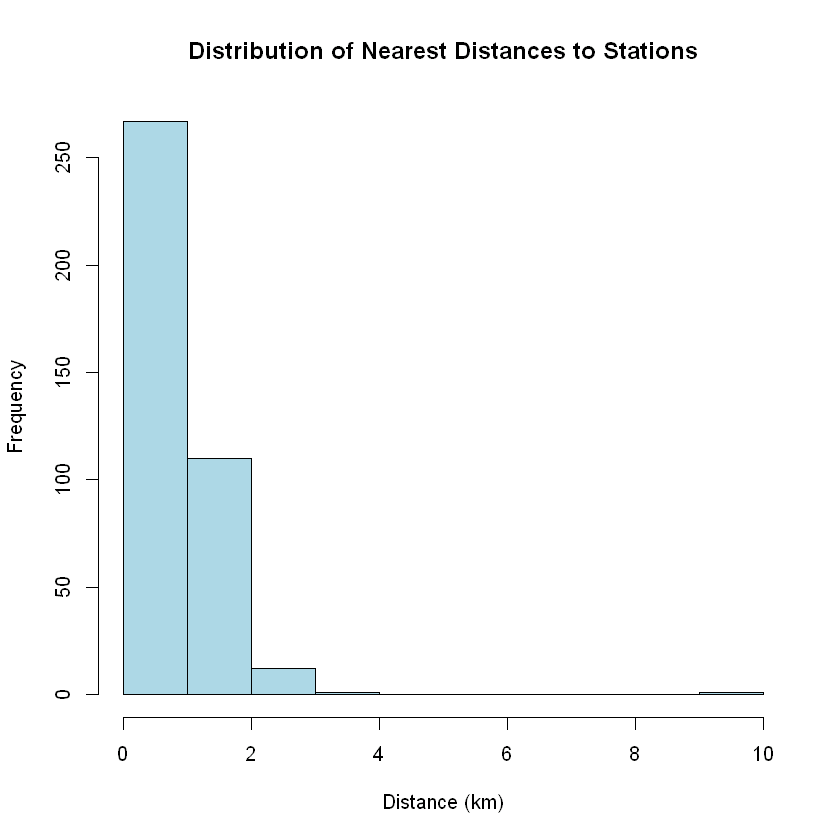

In [15]:
# Check the distribution of closest distances
hist(airport_data$Closest_Distance, main="Distribution of Nearest Distances to Stations",
     xlab="Distance (km)", ylab="Frequency", col="lightblue")

# Display any distances greater than a threshold, e.g., 25 km, for closer inspection
large_distances <- airport_data[airport_data$Closest_Distance > 25, ]
print(large_distances)

In [16]:
# Save the final data to a CSV file
write.csv(airport_data, "Airport_with_Nearest_Station.csv", row.names = FALSE)
cat("Airport data with nearest station information has been saved to 'Airport_with_Nearest_Station.csv'\n")

Airport data with nearest station information has been saved to 'Airport_with_Nearest_Station.csv'
